In [4]:
! sudo apt update -y && sudo apt-get install -y poppler-utils -qq

Hit:1 http://deb.debian.org/debian bullseye InRelease       
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Hit:4 https://dl.yarnpkg.com/debian stable InRelease33m
Fetched 92.4 kB in 5s (17.6 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
6 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [74]:
! pip install pdf2image fpdf2 datasets --quiet

In [123]:
import datasets
from pdf2image import convert_from_bytes
from fpdf import FPDF
from io import BytesIO
from PIL import Image
import os
import json
import pandas as pd
SELECT_RANGE = 4_000

In [124]:
dataset = datasets.load_dataset("cc_news")

In [125]:
dataset = dataset["train"]

In [126]:
sample = dataset.select(range(10))["text"]

In [127]:
class SimpleDoc(FPDF):
    def __init__(self) -> None:
        super().__init__()
        self.ch = 8
        return

    def header(self) -> None:
        return

    def footer(self) -> None:
        return
    
    def body(self, text: str) -> None:
        ch = self.ch
        text = text.encode("UTF-8")
        self.add_page()
        self.set_font('Arial', 'B', 8)
        self.multi_cell(0, 5, text.decode("Latin-1"))
        # Line break
        self.ln()

In [128]:
doc = SimpleDoc()

In [129]:
sample[-1]

'Looking for your next audition shoe? Shot at and in collaboration with Broadway Dance Center, Só Dança has launched a new collection of shoes working with some pretty famous faces of the musical theater world! Offered in two different styles and either 2.5" or 3" heels, top industry professionals are loving how versatile and supportive these shoes are! Pro tip: The heel is centered under the body so you can feel confident and stable!'

In [130]:
doc.body(text=sample[-1])

/tmp/ipykernel_429314/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)


In [133]:
stream = BytesIO(doc.output(dest="S"))
stream.seek(0)
images = convert_from_bytes(stream.read(), 200)
for i, image in enumerate(images):
    image.save("/tmp/test.png")

/tmp/ipykernel_429314/2280367534.py:1: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))


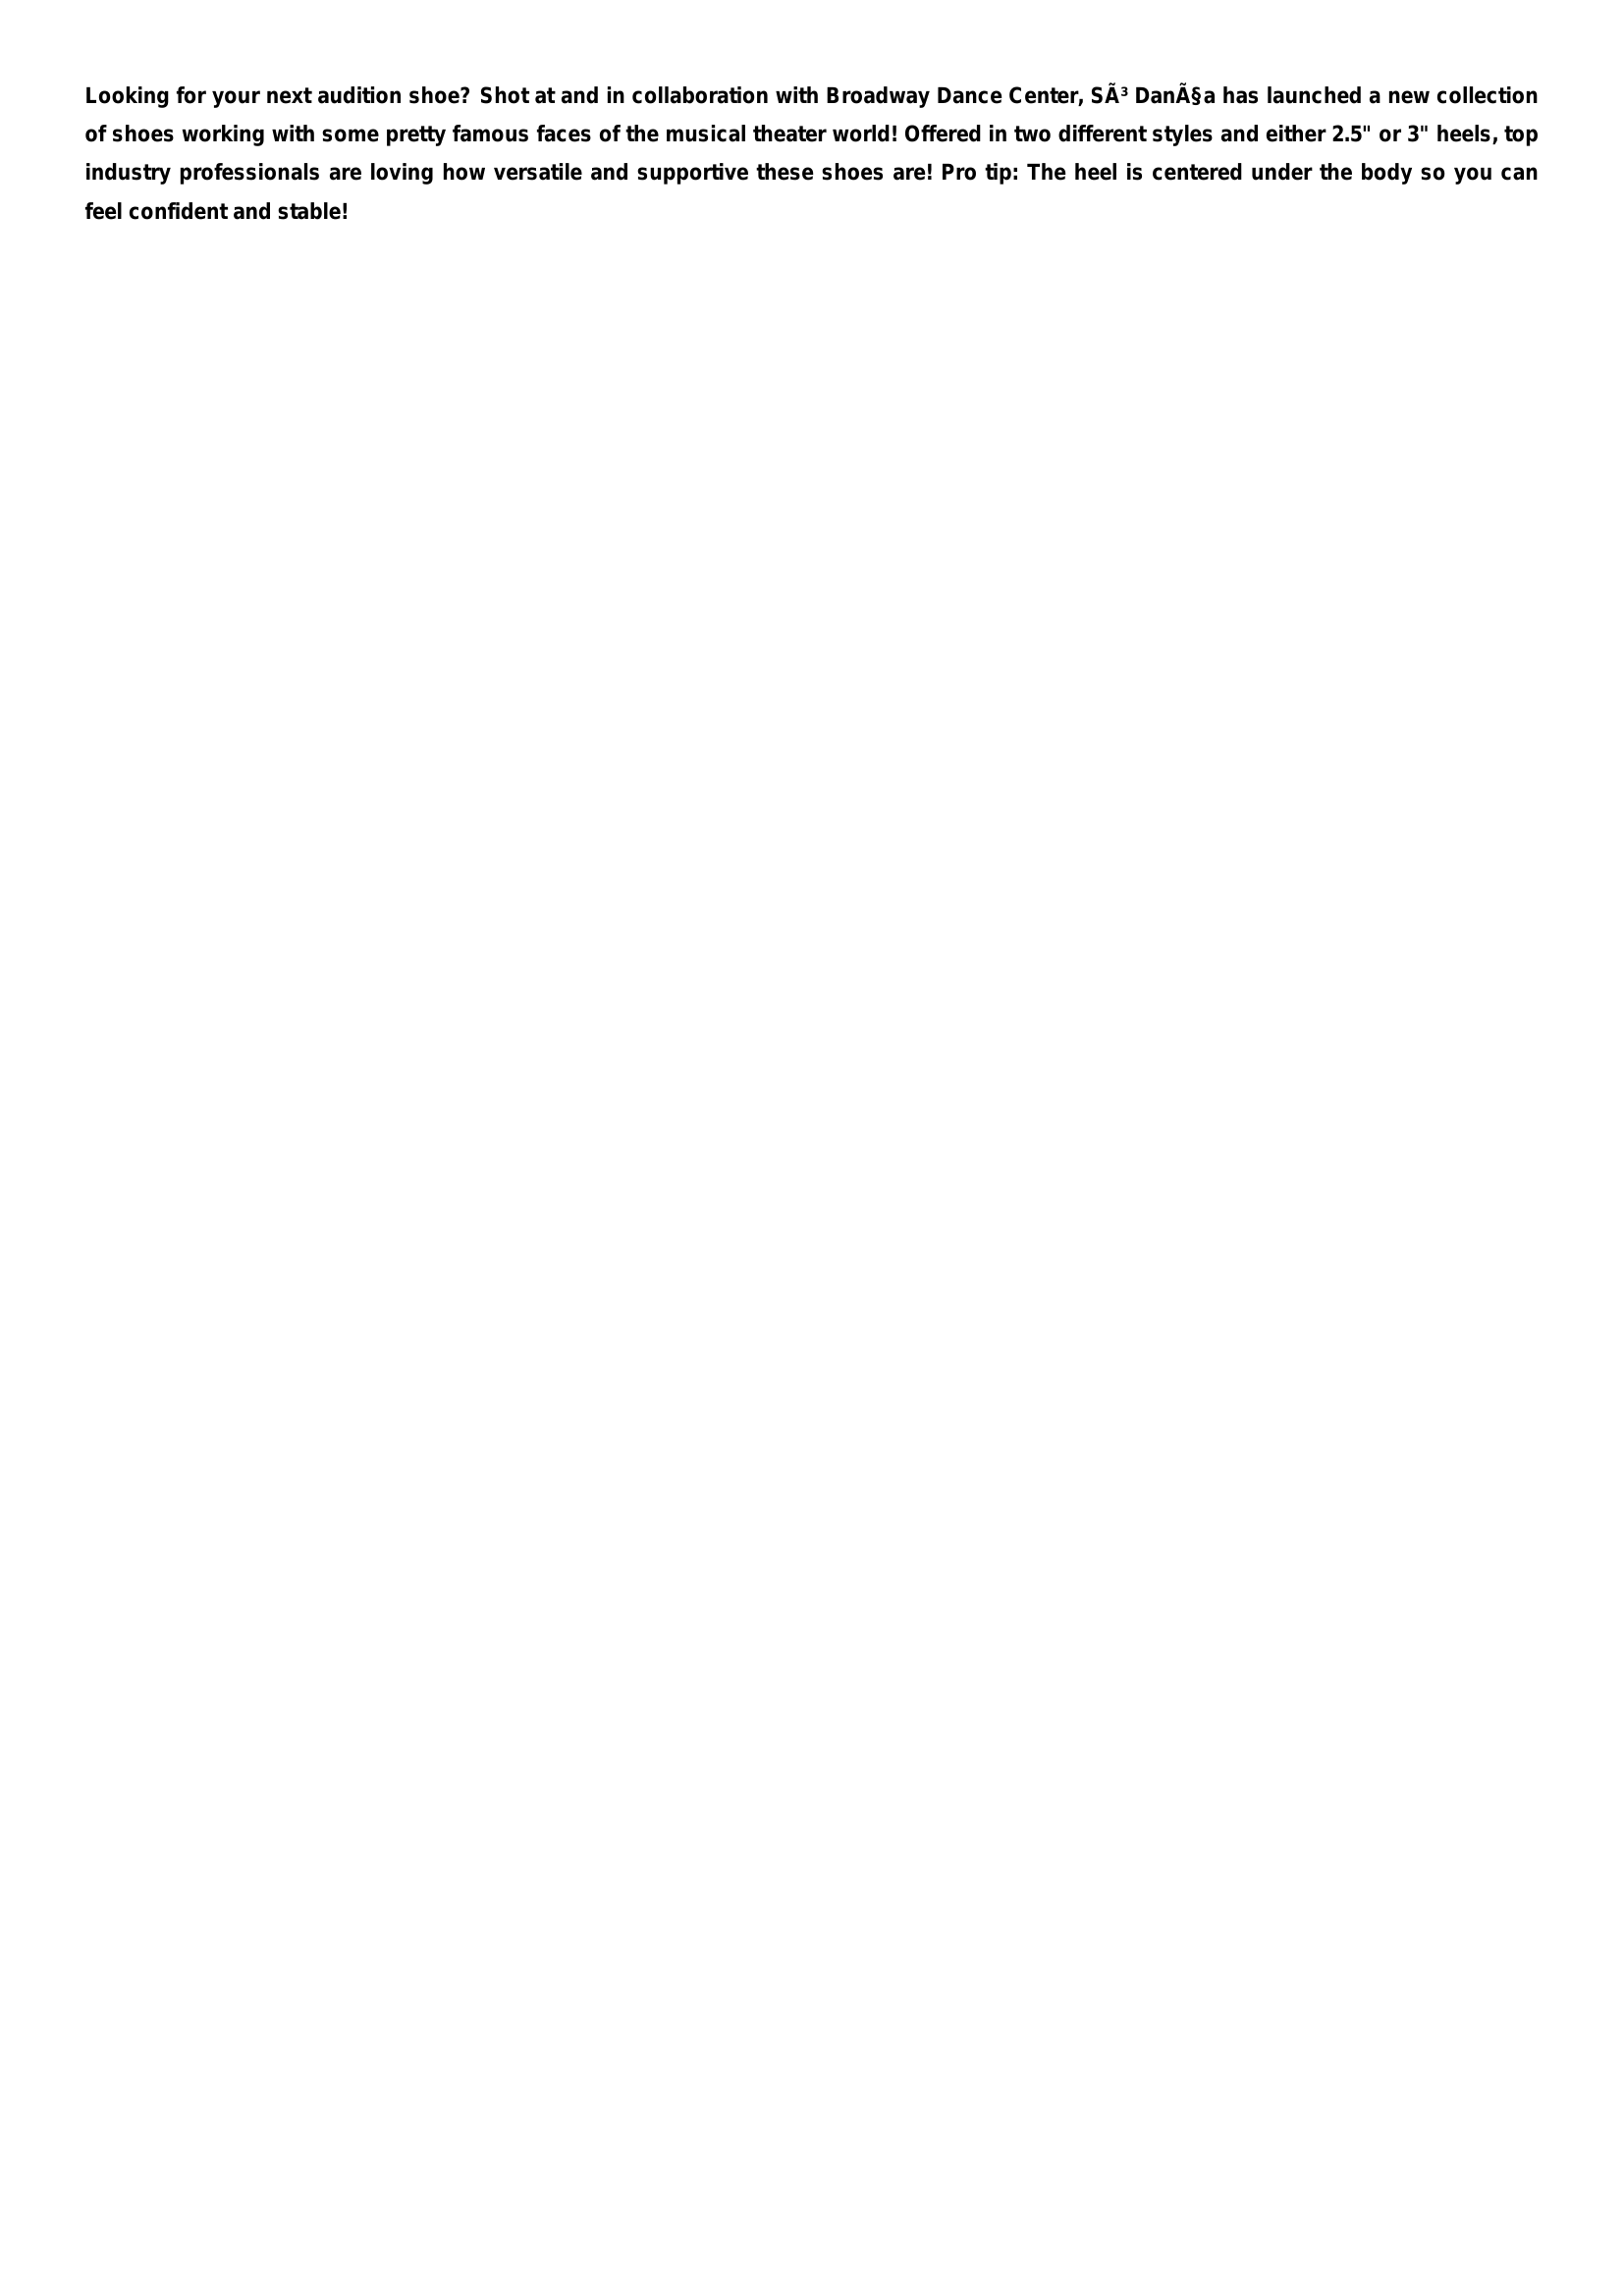

In [134]:
Image.open("/tmp/test.png")

### Load Data And Product Image Dataset

In [135]:
doc_set = (
    dataset
    .shuffle()
    .select(range(SELECT_RANGE))
    .select_columns(["text"])
).to_pandas()


In [136]:
metadata = []
for i, row in enumerate(doc_set.itertuples()):
    doc = SimpleDoc()
    doc.body(text=row.text)
    stream = BytesIO(doc.output(dest="S"))
    stream.seek(0)
    base_dir = "/tmp/cc_news_images"
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    for j, image in enumerate(convert_from_bytes(stream.read(), 200)):
        filename = f"{base_dir}/doc_{i}-{j}.png"
        record = dict(file_name=f"doc_{i}-{j}.png", text=row.text)
        metadata.append(record)
        image.save(filename)
    del(doc)
    del(stream)

/tmp/ipykernel_429314/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_429314/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_429314/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_429314/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_429314/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_429314/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_429314/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_fo

In [137]:
metadata

[{'file_name': 'doc_0-0.png',
  'text': "Emmanuel Macron, head of the political movement En Marche !, or Onwards !, and candidate for the 2017 presidential election, poses before taking part in the show ''Elysee 2017'' on French television channel TF1 in Paris, France, April 27, 2017. REUTERS/Eric Feferberg/Pool\nPARIS A new Odoxa survey of voter intentions said centrist Emmanuel Macron would win the French presidency in a May 7 vote, but that his share of the vote would be 59 percent, down four percentage points from its previous survey.\nThe survey, carried out over April 26-27 and published on Friday, saw his far right rival Marine Le Pen on 41 percent, up four points compared with the previous survey on April 24-25.\nThe poll showed that 40 percent of supporters of the defeated first-round French presidential candidate Jean-Luc Melenchon would vote Emmanuel Macron, while half of Francois Fillon voters would do the same.\nMore than 40 percent of Melenchon voters plan to abstain, the

In [138]:
pd.DataFrame(metadata).to_csv(f"{base_dir}/metadata.csv", index=False)

In [139]:
dt_sample = datasets.load_dataset("imagefolder", data_dir="/tmp/cc_news_images/", split="train[:10%]")
dt_train = datasets.load_dataset("imagefolder", data_dir="/tmp/cc_news_images/", split="train[:70%]")
dt_test = datasets.load_dataset("imagefolder", data_dir="/tmp/cc_news_images/", split="train[70%:]")

Resolving data files: 100%|██████████| 4390/4390 [00:00<00:00, 62111.64it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 4389 examples [00:00, 12040.48 examples/s]


Resolving data files: 100%|██████████| 4390/4390 [00:00<00:00, 452541.16it/s]


In [140]:
tbl = datasets.DatasetDict(
    {
        "sample": dt_sample,
        "train": dt_train,
        "test": dt_test, 
    }
)
tbl

DatasetDict({
    sample: Dataset({
        features: ['image', 'text'],
        num_rows: 439
    })
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 3072
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1317
    })
})

In [142]:
tbl.push_to_hub("lowem1/cc_news_images")

Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [07:33<00:00, 453.86s/it]
